# Demo No. 12 - Light curve fitting.

This demo will guide you trough a process of inferring a parameters of the eclipsing binary from the shape of the light curve. We will stat again by importing necessary modules and setting our loging:

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import os
import astropy.units as u

from elisa.conf import config
from elisa.analytics import LCData, LCBinaryAnalyticsTask
from elisa.analytics.params.parameters import BinaryInitialParameters


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging() 

In this particular case of KIC 4851217, we will help ourselves by using previous results obtained from radial velocity fit. In particular, radial velocities are much more sensitive to mass ratio of the components, therefore we will adopt the value obtained in previous demo and we will keep it fixed. 

The procedure itself is very similar to the one mentioned in the previous demo 11. Initially, we will initiate the dataset with our Kepler phase curve:

In [2]:
kepler_data = LCData.load_from_file(filename='demo_data/lc_data/kepler_phs_crv.dat', 
                                    x_unit=u.dimensionless_unscaled, 
                                    y_unit=u.dimensionless_unscaled
                                   )

Lets finally define our starting parameters. Starting parameters are divided to system, primary and secondary category listed in form of dictionaries that contain name of the variable as a key and values contains dictionary characterizing starting value of the parameter, status of the parameter (fixed: True/False), the boundaries of the fitted parameter defined by min, max values and the unit in astropy format. In case of parameter `semi_major_axis` we utilized the capability to constraint parameter to the `system@inclination` parameter since a*sin(i) parameter has been determined during radial velocity fit:

In [3]:
lc_initial = {
    'system': {
        'inclination': {
            'value': 81.0,
            'fixed': False,
            'min': 79,
            'max': 83,
            'unit': u.deg
        },
        'eccentricity': {
            'value': 0.01,
            'fixed': False,
            'min': 0.00,
            'max': 0.05,
        },
        'mass_ratio': {
            'value': 1.077,
            'fixed': True,
        },  # value obtained during RV fit
        'argument_of_periastron': {
            'value': 285,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },  # similar case to eccentricity
        'semi_major_axis': {
            'constraint': '11.86 / sin(radians(system@inclination))'
        },  # using parameter asin(i) obtained from RV fit
        'period': {
            'value': 2.47028376,
            'fixed': True,
            'unit': u.d
        },
        'additional_light': {
            'value': 0.2415143632,
            'fixed': False,
            'min': 0.20,
            'max': 0.30,
        },  # there is strong evidence for the presence of the third body
        'phase_shift': {
            'value': 0,
            'fixed': False,
            'min': -0.02,
            'max': 0.02,
        },  # accounting for imprecision of the ephemeris
    },
    'primary': {
        't_eff': {
            'value': 7022.0,
            'fixed': True,
            'unit': u.K
        },  # fixed to value found in literature
        'surface_potential': {
            'value': 8.1,
            'fixed': False,
            'min': 7.6,
            'max': 8.7,
        },
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
    },
    'secondary': {
        't_eff': {
            'value': 6961.75240,
            'fixed': False,
            'min': 6700.0,
            'max': 7300.0,
            'unit': u.K
        },
        'surface_potential': {
            'value': 5.2,
            'fixed': False,
            'min': 4.8,
            'max': 5.8,
        },
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },  # we are presuming radiative envelopes on both components
    },
}

Subsequently, we will initialize initial parameter object based on our input parameters:

In [4]:
lc_params = BinaryInitialParameters(**lc_initial)

## Least squares method

We will start by initialization of the fitting task instance, where light curves are provided as values of dictionary with passband names as their corresponding keys. The fitting method (`least_squares` or `mcmc`) and expected morphology needs to be specified as well (`detached` or `over-contact`):

In [5]:
lst_sqr_task = LCBinaryAnalyticsTask(data={'Kepler': kepler_data}, method='least_squares', expected_morphology="detached")

Make sure that `light_curve` argument keys i.e. passband names are identical to passband names accesible for your Elisa install:

In [6]:
config.PASSBANDS

['bolometric',
 'Generic.Bessell.U',
 'Generic.Bessell.B',
 'Generic.Bessell.V',
 'Generic.Bessell.R',
 'Generic.Bessell.I',
 'SLOAN.SDSS.u',
 'SLOAN.SDSS.g',
 'SLOAN.SDSS.r',
 'SLOAN.SDSS.i',
 'SLOAN.SDSS.z',
 'Generic.Stromgren.u',
 'Generic.Stromgren.v',
 'Generic.Stromgren.b',
 'Generic.Stromgren.y',
 'Kepler',
 'GaiaDR2']

Similarly to rv_fit module, we can fit parameter combinations in `standard` and `community` approach. We can acces lists of available parameters in a similar fashion:

In [7]:
print(lst_sqr_task.FIT_PARAMS_COMBINATIONS)

{
    "standard": {
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "period",
            "primary_minimum_time",
            "additional_light",
            "phase_shift"
        ],
        "primary": [
            "mass",
            "t_eff",
            "surface_potential",
            "gravity_darkening",
            "albedo",
            "synchronicity",
            "metallicity",
            "spots",
            "pulsations"
        ],
        "secondary": [
            "mass",
            "t_eff",
            "surface_potential",
            "gravity_darkening",
            "albedo",
            "synchronicity",
            "metallicity",
            "spots",
            "pulsations"
        ]
    },
    "community": {
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "period",
            "semi_major_axis",
            "primary_

Where we used "constrained" parameter `semi_major_axis` to make use of the `asini` parameter obtained during RV fit. Constraint itself is provided in form of a string where other fit parameters to which constraint is attached are in curly brackets. List of available operators and numerals that can be used to form constraint can be accesed here:

In [8]:
lst_sqr_task.CONSTRAINT_OPERATORS

['arcsin',
 'arccos',
 'arctan',
 'log',
 'sin',
 'cos',
 'tan',
 'exp',
 'degrees',
 'radians',
 '(',
 ')',
 '+',
 '-',
 '*',
 '/',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

Before fit itself, it is recommended to make use of multiprocessig capabilities of this package. The least squares method is serially executed method, therefore parallelization has to be implemented during claculation of each light curve. This can be achieved by setting configuration variable `NUMBER_OF_PROCESSES` in this script or by setting `number_of_processes` parameter in you config file: 

In [9]:
config.NUMBER_OF_PROCESSES = os.cpu_count()  # this will make sure to utilize all available processors

We can now finally perfom the fit itself. As in the previous demo, we will start with the least squares method. Due to the fact that we expect the system to be detached, we specified the `morphology` argument to be 'detached' instead of 'over-contact'. We also reduced the discredization factor of the primary component to 10 since we expect much larger secondary component compared to the primary component. Suitable value of discredization factor can reduce computational time significantly. Interpolation treshold `interp_treshold` defines maximum number of points in observed data, above which synthetic light curve will be calculated on `interp_treshold` equidistant phases that will be subsequently interpolated to produce residuals for every observed data point. 

In [10]:
param_file = 'demo_data/aux/lc_least_squares.json'

# # this part can take a few hours to complete in case of eccentric orbit
# lst_sqr_result = lst_sqr_task.fit(x0=lc_initial, discretization=10, interp_treshold=150, nfev=50, ftol=1e-3)
# lst_sqr_task.save_result(param_file)

# loading pre-calculated results
lst_sqr_task.load_result(param_file)
lst_sqr_result = lst_sqr_task.get_result()
lst_sqr_task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077                   -                   -                None    Fixed                                             
Semi major axis (a):                              11.998                   -                   -              solRad    11.86 / sin(radians(system@inclination))          
Inclination (i):                                    81.3                   -                   -                 deg    Variable                                          
Eccentricity (e):                                   0.03                   -                   -                None    Variable                                          
Arg

The resulting model can be visualized as well:

<IPython.core.display.Javascript object>


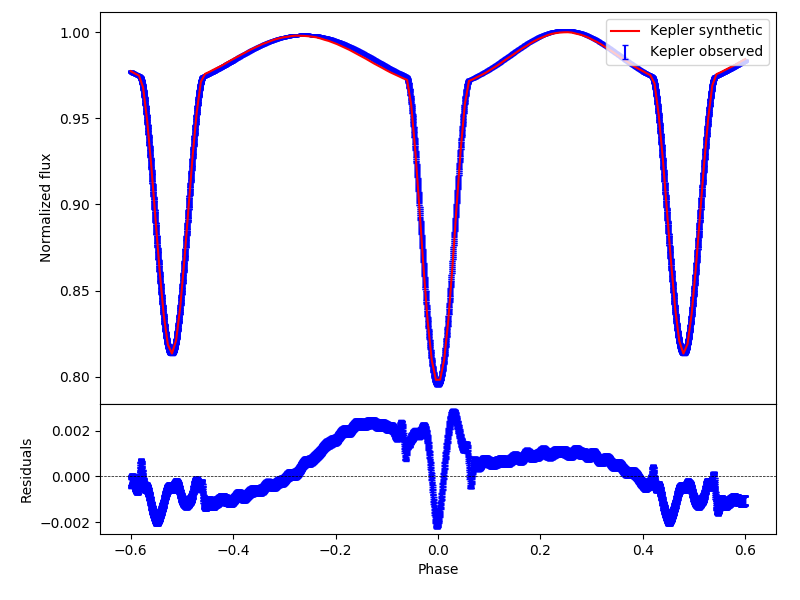

In [11]:
lst_sqr_task.plot.model(discretization=10, number_of_points=150, start_phase=-0.6, stop_phase=0.6)

## Markov chain Monte Carlo (MCMC)

Markov chain Monte Carlo (MCMC) is also implemented for light curve fitting module and it serves similar purpose, to produce reliable error estimates on fitted parameters of the eclipsing binary. Since this method supports parallel approach, we can change our approach to paralelism by changing few config variables since it turns out to be much more efficient to parallelize the MCMC sampling on the level of the MCMC method itself:

In [11]:
config.NUMBER_OF_PROCESSES = 1  # we want a single process approach on the light curve integration level
config.NUMBER_OF_MCMC_PROCESSES = os.cpu_count() # multiple MCMC walkers evaluated at once, each MCMC will use single core approach to obtain the curve

Least squares method already found approximate position of the solution and the good coverage of the phase curve means that we can probably trust that solution and use it as a starting point for our MCMC sampling. Estimation on the size of the searching box for each parameter is left to user, however, the validity of the selected interval can be asserted aposteriori by studying the traces where you should avoid any clipping of your chain distribution by the borders of the searching box. With some adjustments, we will adopt results of the least square fit as our starting parameters:

In [12]:
# residual phase shift was sufficiently determined in least sqares fit, therefore it will stay fixed during mcmc sampling
lst_sqr_result['system']['phase_shift']['fixed'] = True
lc_params = BinaryInitialParameters(**lst_sqr_result)

As in previous case, we need to define fitting task instance, but this time with `mcmc` in our `method` argument:

In [13]:
mcmc_task = LCBinaryAnalyticsTask(data={'Kepler': kepler_data}, method='mcmc', expected_morphology='detached')

The initial vector can now be used to perform MCMC sampling. In this case, path to desired location of the result file on disk was used as `fit_id` argument:

In [16]:
param_file = 'demo_data/aux/lc_mcmc_params.json'
chain_file = 'demo_data/aux/lc_mcmc_chain.json'

# MCMC sampling takes a long time
# mcmc_params = mcmc_task.fit(x0=lc_params, nsteps=200, nwalkers=100, burn_in=0,
#                             discretization=10, interp_treshold=150, progress=True, fit_id=chain_file, save=True)

# due to very time consuming nature of a MCMC sampling, we will load pre-calculated results
mcmc_task.load_result(param_file)
mcmc_task.load_chain(chain_file)
mcmc_task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077                   -                   -                None    Fixed                                             
Semi major axis (a):                              11.995                   -                   -              solRad    11.86 / sin(radians(system@inclination))          
Inclination (i):                                   81.39                0.56                0.19                 deg    Variable                                          
Eccentricity (e):                                0.03378             0.00245             0.00082                None    Variable                                          
Arg

With `burn_in` parameter 0 we have to inspect traces not only for any sign of clipping but also we have to determine how big portion of the chain belongs to the thermalization stage and has to be discarded:

<IPython.core.display.Javascript object>


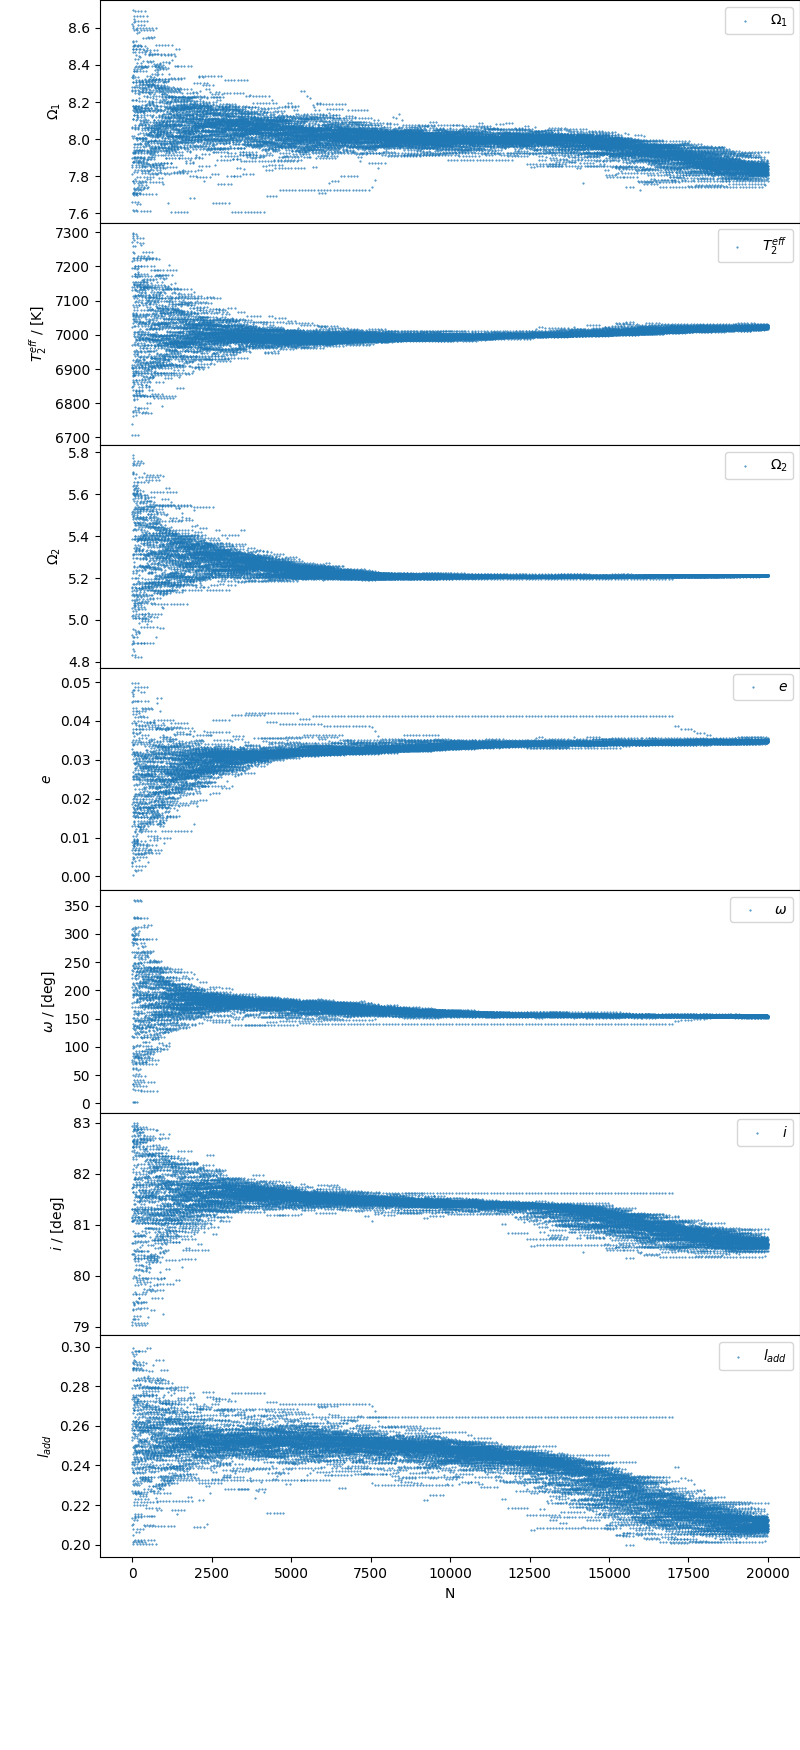

In [17]:
mcmc_task.plot.traces()

Here we can see that chain was not able to reach sampling phase after roughly 10000 steps, therefore longer chain is needed to produce desired results. Suppose however, that the equilibrium was reached after 10000 do we have to discard the first 10000 steps by using `discard` argument:

In [20]:
mcmc_task.load_chain(chain_file, discard=10000)

And plot the corner plot:

<IPython.core.display.Javascript object>


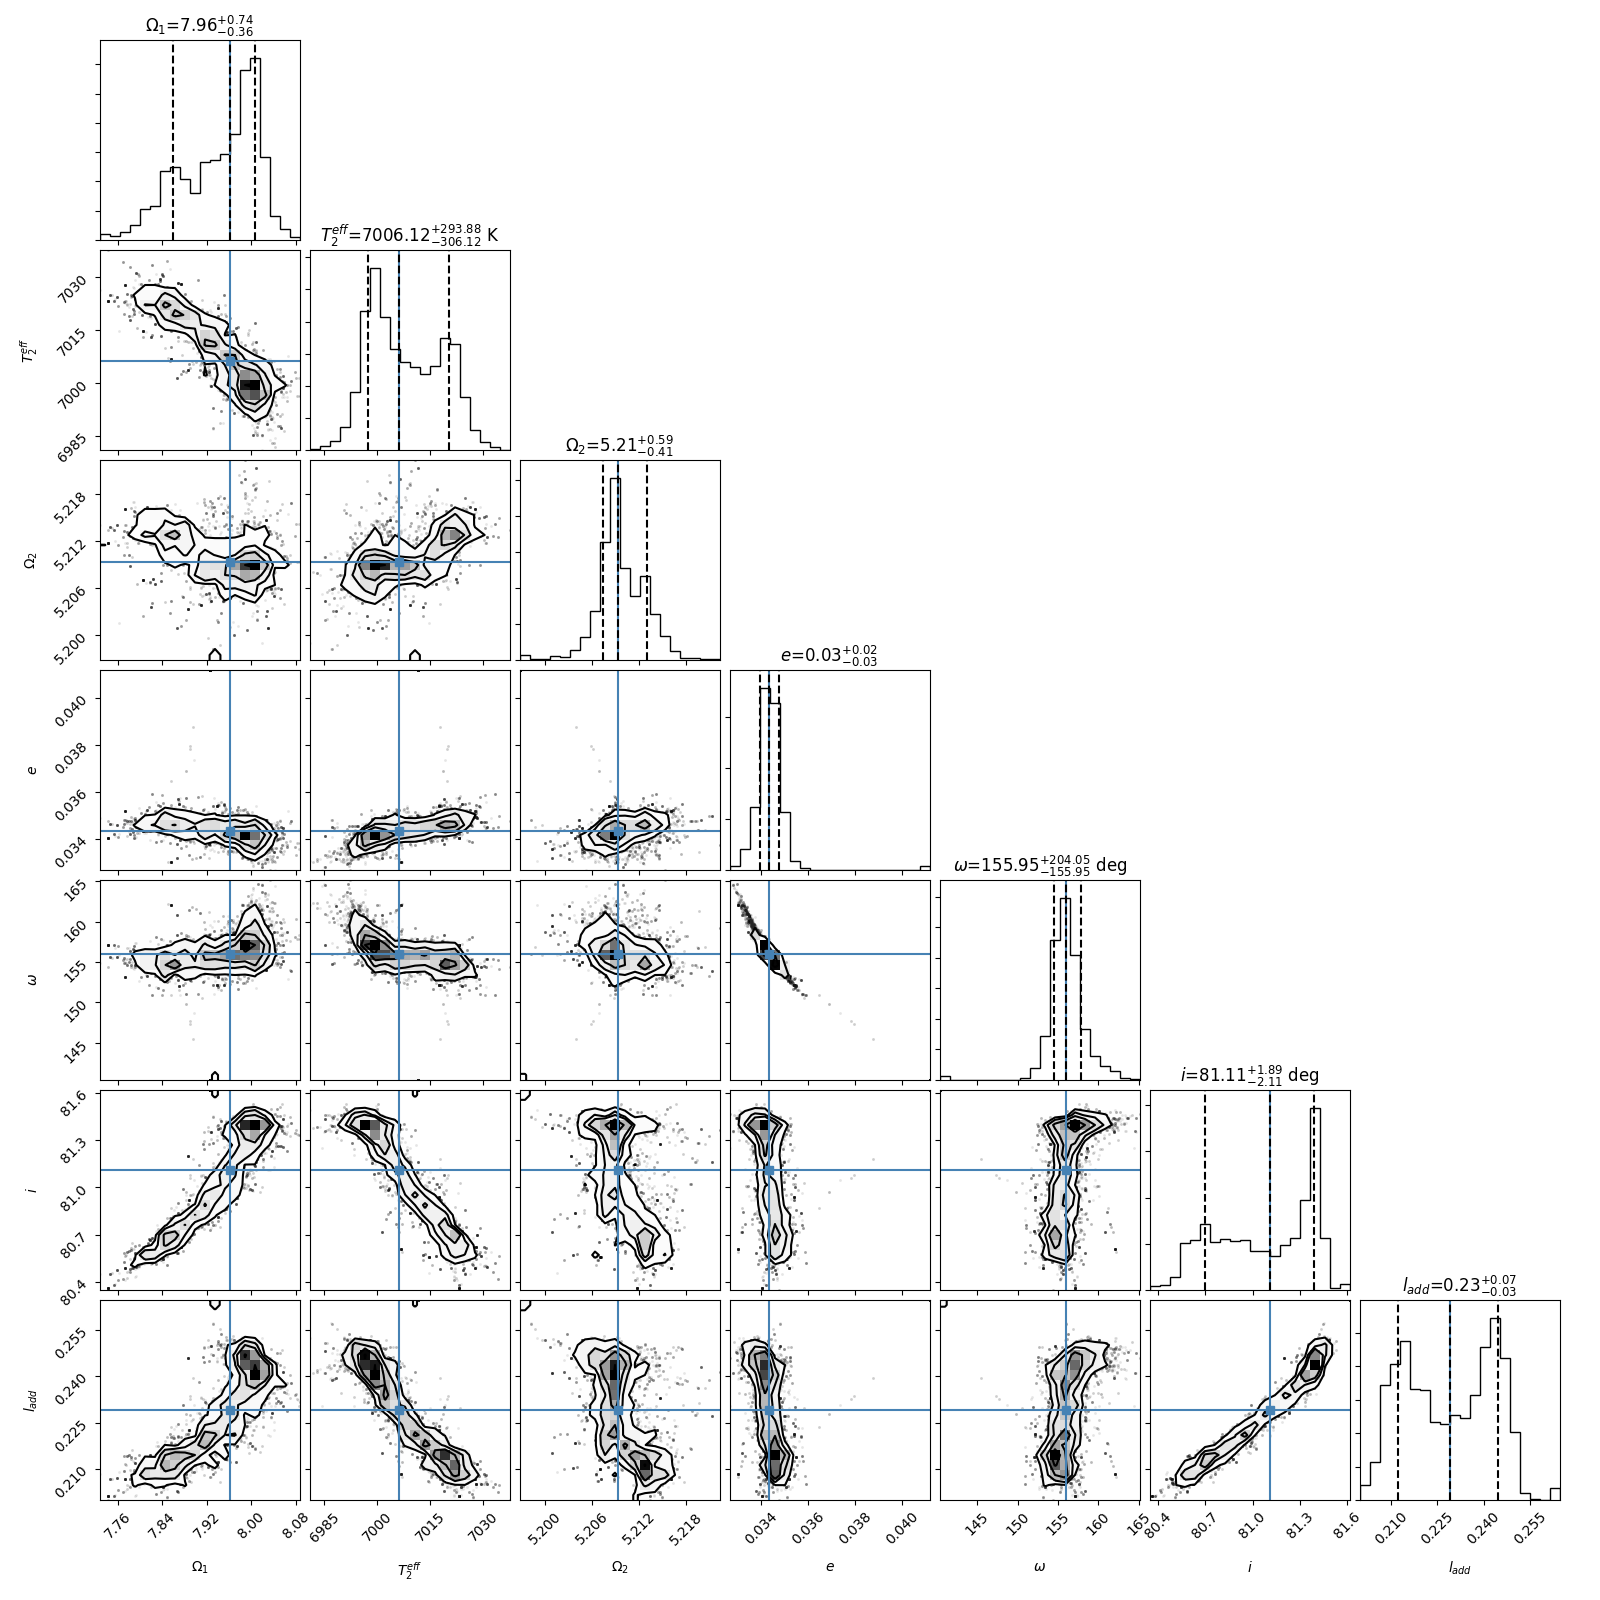

In [21]:
mcmc_task.plot.corner(truths=True)

As it is obvious from the corner plot, these results suffer from severe correlation and the longer chain is necessary to reach sampling phase.